In [36]:
options(repos = c(CRAN = "https://cloud.r-project.org"))

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stringr, readxl, data.table, gdata, scales, data.table)

source("..//functions-1.R")

In [37]:
data.2014 <- read.csv('../data/output/data-2014.csv')
data.2015 <- read.csv('../data/output/data-2015.csv')
data.2016 <- read.csv('../data/output/data-2016.csv')
data.2017 <- read.csv('../data/output/data-2017.csv')
data.2018 <- read.csv('../data/output/data-2018.csv')
data.2019 <- read.csv('../data/output/data-2019.csv')

In [38]:
data.full <- rbind(data.2014, data.2015, data.2016, data.2017, data.2018, data.2019)

glimpse(data.full)

Rows: 449,046
Columns: 61
$ contractid          <chr> "H0022", "H0022", "H0022", "H0022", "H0022", "H002…
$ planid              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4,…
$ fips                <int> 39023, 39035, 39051, 39055, 39057, 39085, 39093, 3…
$ year.x              <int> 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 20…
$ n_nonmiss           <int> 6, 8, 7, 0, 6, 8, 8, 7, 8, 6, 4, 7, 12, 12, 12, 12…
$ avg_enrollment      <dbl> 72.00000, 330.12500, 24.57143, NA, 120.83333, 41.5…
$ sd_enrollment       <dbl> 7.2111026, 10.6158574, 1.8126539, NA, 15.7659972, …
$ min_enrollment      <int> 60, 309, 23, NA, 90, 39, 29, 299, 24, 431, 11, 71,…
$ max_enrollment      <int> 81, 344, 28, NA, 135, 44, 43, 440, 26, 713, 12, 85…
$ first_enrollment    <int> 60, 309, 24, NA, 90, 41, 29, 299, 24, 431, 11, 71,…
$ last_enrollment     <int> 81, 344, 24, NA, 135, 44, 43, 440, 24, 713, 12, 82…
$ state               <chr> "OH", "OH", "OH", "OH", "OH", "OH", "OH", "OH", "O…
$ county      

Problem 1


In [39]:
plan_counts <- data.full %>% group_by(fips) %>% count(county, year.x, name = "plan_count")

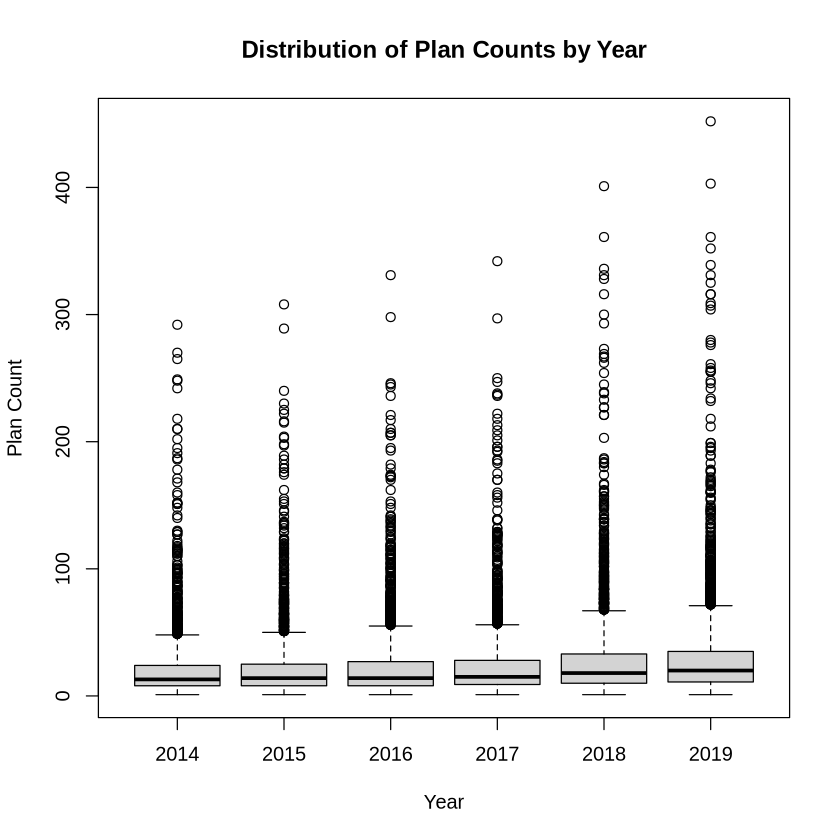

In [40]:
boxplot(plan_count ~ year.x, data = plan_counts,
        xlab = "Year",
        ylab = "Plan Count",
        main = "Distribution of Plan Counts by Year")

Problem 2


In [41]:
data.full <- data.full %>% mutate (basic_premium = case_when(
        rebate_partc > 0 ~ 0,
        partd == "No" & !is.na(premium) & is.na(premium_partc) ~ premium,
        TRUE ~ premium_partc
      ),
      bid = case_when(
        rebate_partc == 0 & basic_premium > 0 ~ (payment_partc + basic_premium) / riskscore_partc,
        rebate_partc > 0  | basic_premium == 0 ~  payment_partc / riskscore_partc,
        TRUE ~ NA_real_
      )
    )

Warning message:
“Removed 8956 rows containing non-finite values (`stat_bin()`).”


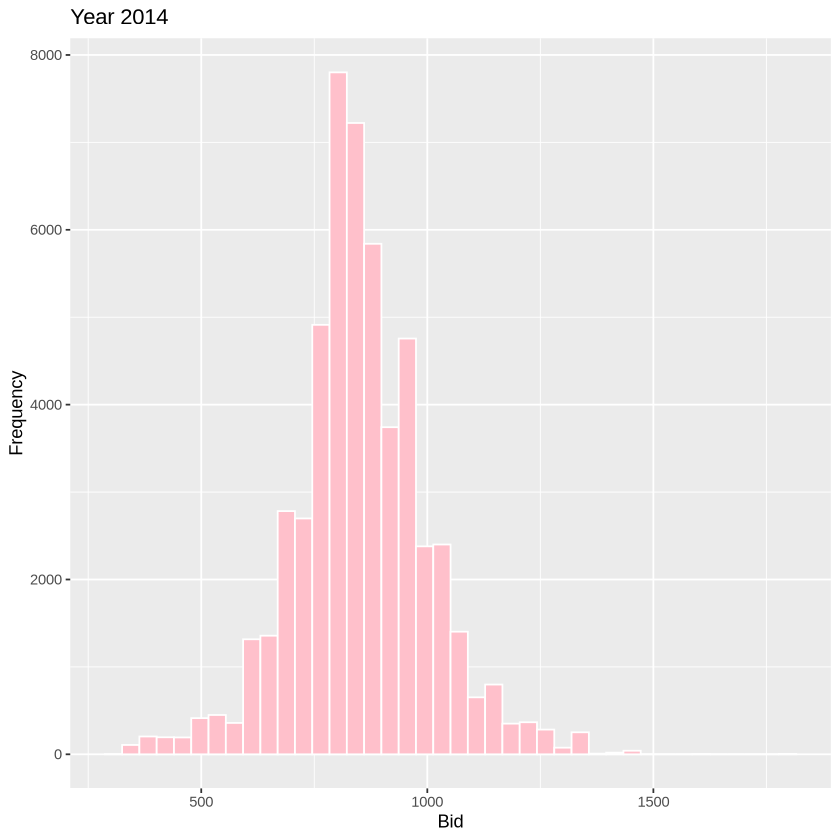

In [42]:
data.full %>%
  filter(year.x == 2014) %>%
  ggplot(aes(x = bid)) +
  geom_histogram(bins = 40, fill = "pink", color = "white")+
  labs(
    x = "Bid",
    y = "Frequency",
    title = "Year 2014"
  )

Warning message:
“Removed 8094 rows containing non-finite values (`stat_bin()`).”


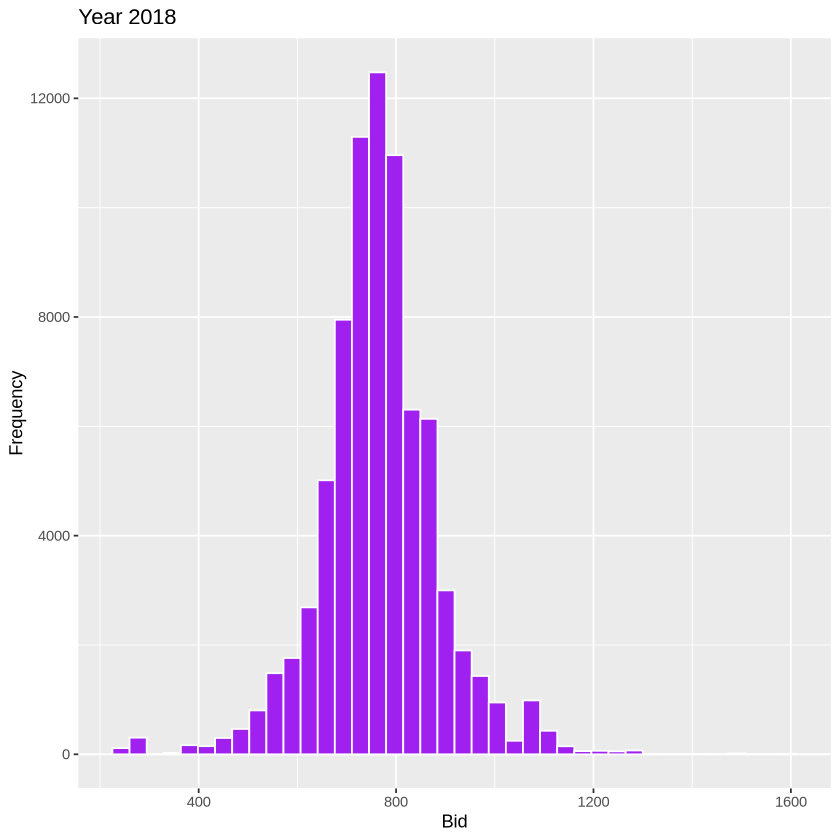

In [43]:
data.full %>%
  filter(year.x == 2018) %>%
  ggplot(aes(x = bid)) +
  geom_histogram(bins = 40, fill = "purple", color = "white")+
  labs(
    x = "Bid",
    y = "Frequency",
    title = "Year 2018"
  )

Problem 3


In [44]:
hhi_data <- data.full %>%
  mutate(share = avg_enrollment / avg_enrolled) %>%
  group_by(fips, year.x) %>%
  summarise(HHI = sum(share^2, na.rm = TRUE), .groups = "drop") %>% 
  group_by(year.x) %>% 
  summarise(mean_HHI = mean(HHI, na.rm = TRUE), .groups = "drop")

In [45]:
hhi_data

year.x,mean_HHI
<int>,<dbl>
2014,0.1722958
2015,0.1672992
2016,0.1673735
2017,0.1570308
2018,0.1373105
2019,0.1177533


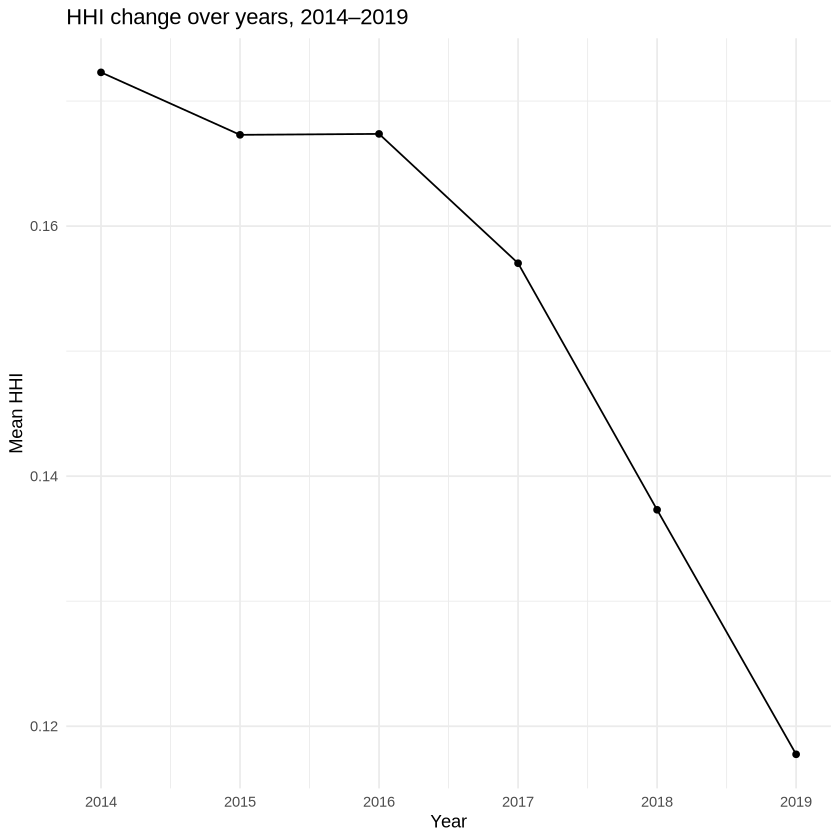

In [46]:
ggplot(hhi_data, aes(x = year.x, y = mean_HHI)) + geom_line() + geom_point() + theme_minimal() + labs(
    x = "Year",
    y = "Mean HHI",
    title = "HHI change over years, 2014–2019"
  )

Problem 4


In [47]:
ma_share_yearly <- data.full %>%
  mutate(ma_share = avg_enrolled / avg_eligibles) %>%
  group_by(year.x) %>%
  summarise(mean_share = mean(ma_share, na.rm = TRUE), .groups = "drop")

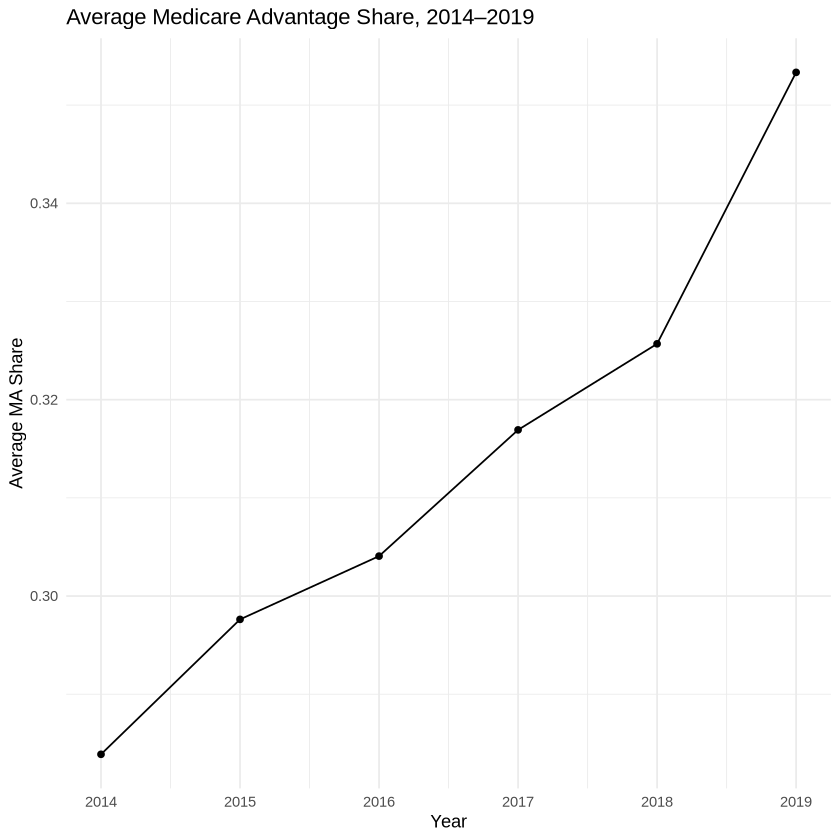

In [48]:
ggplot(ma_share_yearly, aes(x = year.x, y = mean_share)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(
    x = "Year",
    y = "Average MA Share",
    title = "Average Medicare Advantage Share, 2014–2019"
  )

Estimate ATEs

Problem 5


In [49]:
data.full.2018 <- data.full %>% filter(year.x == 2018)

In [50]:
colnames(data.full.2018)

[1] "contractid"          "planid"              "fips"               
 [4] "year.x"              "n_nonmiss"           "avg_enrollment"     
 [7] "sd_enrollment"       "min_enrollment"      "max_enrollment"     
[10] "first_enrollment"    "last_enrollment"     "state"              
[13] "county"              "org_type"            "plan_type"          
[16] "partd"               "snp"                 "eghp"               
[19] "org_name"            "org_marketing_name"  "plan_name"          
[22] "parent_org"          "contract_date"       "state_long"         
[25] "county_long"         "year.y"              "n_elig"             
[28] "n_enrol"             "avg_eligibles"       "sd_eligibles"       
[31] "min_eligibles"       "max_eligibles"       "first_eligibles"    
[34] "last_eligibles"      "avg_enrolled"        "sd_enrolled"        
[37] "min_enrolled"        "max_enrolled"        "first_enrolled"     
[40] "last_enrolled"       "ssa"                 "ncount"             
[43] "state_name"          "premium"             "premium_partc"      
[46] "premium_partd_basic" "premium_partd_supp"  "premium_partd_total"
[49] "partd_deductible"    "year.x.x"            "riskscore_partc"    
[52] "payment_partc"       "rebate_partc"        "year.y.y"           
[55] "payment_partd"       "directsubsidy_partd" "reinsurance_partd"  
[58] "costsharing_partd"   "riskscore_partd"     "basic_premium"      
[61] "bid"

In [51]:
hhi_data_2018 <- data.full.2018 %>%
  mutate(share = avg_enrollment / avg_enrolled) %>%
  group_by(fips, year.x) %>%
  mutate(HHI = sum(share^2, na.rm = TRUE)) %>%
  ungroup()

In [52]:
hhi_data_33 <- quantile(hhi_data_2018$HHI, 0.33, na.rm = TRUE)
hhi_data_66 <- quantile(hhi_data_2018$HHI, 0.66, na.rm = TRUE)

In [53]:
hhi_high <- hhi_data_2018 %>% filter(hhi_data_2018$HHI >= hhi_data_66)
hhi_low <- hhi_data_2018 %>% filter(hhi_data_2018$HHI <= hhi_data_33)

In [54]:
avg_high <- hhi_high %>% summarise(avg_66 = mean(bid, na.rm = TRUE))
avg_low <- hhi_low %>% summarise(avg_33 = mean(bid, na.rm = TRUE))

cat("Average Bid in Uncompetitive Markets:", avg_high$avg_66, "\n")
cat("Average Bid in Competitive Markets:", avg_low$avg_33, "\n")

Average Bid in Uncompetitive Markets: 770.536 
Average Bid in Competitive Markets: 767.0241 


Problem 6


In [55]:
data.2018.ffs <- read.csv('../data/output/data-2018-ffs.csv')

In [56]:
data.2018.ffs <- data.2018.ffs %>% mutate(ffs_quartile = ntile(avg_ffscost, 4))

In [57]:
results <- lapply(1:4, function(q) {
  treatment <- data.2018.ffs %>%
    filter(ffs_quartile == q) %>%
    summarise(avg_bid_treat = mean(bid, na.rm = TRUE))

  control <- data.2018.ffs %>%
    filter(ffs_quartile != q) %>%
    summarise(avg_bid_control = mean(bid, na.rm = TRUE))

  data.frame(
    quartile = q,
    avg_bid_treat = treatment$avg_bid_treat,
    avg_bid_control = control$avg_bid_control
  )
})

results_table <- do.call(rbind, results)

print(results_table)

  quartile avg_bid_treat avg_bid_control
1        1      778.7275        761.3458
2        2      769.9289        764.2578
3        3      758.0963        768.2317
4        4      756.0814        768.8580


Problem 7


In [58]:
options(repos = c(CRAN = "https://cloud.r-project.org"))
install.packages("Matching")

Installing package into ‘/home/ssark38/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in install.packages("Matching"):
“installation of package ‘Matching’ had non-zero exit status”


In [59]:
ate_results <- lapply(1:4, function(q) {

dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar = avg_ffscost
    )

dat_q <- dat_q %>% 
  filter(!is.na(outcome), !is.na(treat), !is.na(covar))

nn <- Matching::Match(
    Y = dat_q$outcome,
    Tr = dat_q$treat,
    X = dat_q$covar,
    M = 1,
    Weight = 1,
    estimand = "ATE",
    ties=FALSE
  )

  data.frame(
    quartile = q,
    ATE = nn$est
  )
})

ate_table <- do.call(rbind, ate_results)

print(ate_table)

  quartile       ATE
1        1 -97.08781
2        2  14.60799
3        3  41.16648
4        4 -27.29791


In [67]:
names(ate_table) <- c("quartile", "ate_inv_var")
saveRDS(ate_table, "ate_table_1.rds")

In [68]:
ate_results <- lapply(1:4, function(q) {

dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar = avg_ffscost
    )

dat_q <- dat_q %>% 
  filter(!is.na(outcome), !is.na(treat), !is.na(covar))

nn2 <- Matching::Match(
    Y = dat_q$outcome,
    Tr = dat_q$treat,
    X = dat_q$covar,
    M = 1,
    Weight = 2,
    estimand = "ATE",
    ties=FALSE
  )

  data.frame(
    quartile = q,
    ATE = nn2$est
  )
})

ate_table <- do.call(rbind, ate_results)

print(ate_table)

  quartile       ATE
1        1 -96.95895
2        2  14.90622
3        3  41.28525
4        4 -27.85682


In [69]:
names(ate_table) <- c("quartile", "ate_mahalanobis ")
saveRDS(ate_table, "ate_table_2.rds")

In [75]:
ate_results <- lapply(1:4, function(q) {

dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar = avg_ffscost
    )

dat_q <- dat_q %>% 
  filter(!is.na(outcome), !is.na(treat), !is.na(covar))

logit.model <- glm(treat ~ covar, family = binomial, data = dat_q) 
dat_q$ps <- fitted(logit.model)

dat_q <- dat_q %>% 
    mutate(ipw = case_when( treat == 1 ~ 1/ps, treat == 0 ~ 1/(1 - ps) ))

mean.w1 <- dat_q %>% filter(treat == 1) %>% summarize(mean_y = weighted.mean(outcome, ipw)) 
    
mean.w0 <- dat_q %>% filter(treat == 0) %>% summarize(mean_y = weighted.mean(outcome, ipw))

ate_ipw <- mean.w1$mean_y - mean.w0$mean_y

    data.frame(
    quartile = q,
    ATE = ate_ipw
  )

})

ate_table <- do.call(rbind, ate_results)

print(ate_table)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


  quartile        ATE
1        1  17.255246
2        2   3.416614
3        3  -9.398434
4        4 -12.843000


In [76]:
names(ate_table) <- c("quartile", "ate_ipw")
saveRDS(ate_table, "ate_table_3.rds")

In [77]:
ate_results <- lapply(1:4, function(q) {

dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar = avg_ffscost
    )

dat_q <- dat_q %>% 
  filter(!is.na(outcome), !is.na(treat), !is.na(covar))

reg1.dat <- dat_q %>% filter(treat==1)
reg1 <- lm(outcome ~ covar, data=reg1.dat)

reg0.dat <- dat_q %>% filter(treat==0)
reg0 <- lm(outcome ~ covar, data=reg0.dat)

pred1 <- predict(reg1,new=dat_q)
pred0 <- predict(reg0,new=dat_q)

ate <- mean(pred1-pred0)
    
    data.frame(
    quartile = q,
    ATE = ate
  )

})

ate_table <- do.call(rbind, ate_results)

print(ate_table)

  quartile        ATE
1        1 -9.1913192
2        2 -0.1601797
3        3 -7.4778456
4        4 -3.3832612


In [78]:
names(ate_table) <- c("quartile", "ate_simple_lr")
saveRDS(ate_table, "ate_table_4.rds")

Problem 8. ATE calculated with inverse variance distance and Mahalanobis distance are identical, while the ones calculated with IPW and simple linear regression differ vastly. IPW particularly says the algorithm didn't converge.

Problem 9. We will use my favorite simple linear regression on total Medicare beneficiaries alongside the FFS quartile.


In [79]:
ate_results <- lapply(1:4, function(q) {

  dat_q <- data.2018.ffs %>%
    mutate(
      treat = ifelse(ffs_quartile == q, 1, 0),
      outcome = bid,
      covar1 = avg_ffscost,
      covar2 = n_enrol
    ) %>%
    filter(!is.na(outcome), !is.na(covar1), !is.na(covar2))

  reg1 <- lm(outcome ~ covar1 + covar2, data = dat_q %>% filter(treat == 1))
  reg0 <- lm(outcome ~ covar1 + covar2, data = dat_q %>% filter(treat == 0))

  pred1 <- predict(reg1, newdata = dat_q)
  pred0 <- predict(reg0, newdata = dat_q)

  ate <- mean(pred1 - pred0)

  data.frame(
    quartile = q,
    ATE = ate
  )
})

ate_table <- do.call(rbind, ate_results)
print(ate_table)

  quartile        ATE
1        1 -9.4984154
2        2 -0.1257976
3        3 -7.3484978
4        4 -2.7936440


In [80]:
names(ate_table) <- c("quartile", "ate_total_beneficiaries")
saveRDS(ate_table, "ate_table_5.rds")

It still leads to comparable or identical result when regression was run without total number of Medicare beneficiaries as a covariate.

Problem 10

My experience was fulfilling working with these large data chunks; it really completed my prior experiences. One thing I learned is that my code runs much cleaner and is easier to navigate, as I built most of it from class notes, my concepts, and simple structural logic, rather than using LLMs that I genuinely use strictly for my personal use. One thing that surprised me was how strenuous data management could be when I had to change file names and column ranges while creating cumulative data files for each year, and generalizable RegEx expressions couldn't be deployed.
